# Capstone Project - Final
### Weeks 4 & 5

## Table of contents
* [Introduction: Business Problem](#business_problem)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Business Problem <a name="business_problem"></a>

The city of Ljubljana, capital of Slovenia, has been a very popular tourist destination in the recent  years and it hosts more tourists each year. Also more and more tourists decide to stay in Ljubljana for more than 1 day.  Thus the accommodation offering (hotels, motels, inns, bed & breakfasts etc. ) needs to grow with the demand.  

One of the most important factors when looking for a location for tourist accommodation is location. The goal of this project is to identify parts of the city of Ljubljana  that could be candidates for location for tourist acommodation. 

The report is targeting investors/stakeholders/contractors that are interested in creating new accommodation offerings in Ljubljana. The results should be interesting for either small sized (butique) acommodations as well as higher capacity accommodation.  

There are other factors that impact the decision which are not considered in this project, like realestate prices. 

## Data <a name="data"></a>

The main  datasource will be Foursquare database for the following information:
* Location of existing accommodation venues (any subtype). 
* Location of existing food venues (any subtype).
* Location of existing bus stations/stops. 

Transformations between addresses and geographic locations will be done using the Nomatim API. 

All geographic coordinates calculations will be done in WGS84 geodetic system.

The following assumptions will be considered when trying to find a potential location for tourist accommodation:
* No other tourist accommodation venue in vicinity. 
* Gravitating towards the city center. Most of Ljubljana's attractions are in the city center. 
* Close to existing food & drink venues. We will not distinct on the type of food venue. 
* Close to public transportation grid (bus stations/stops).

In this project we define walking distance as a distance up to 400 meters. This corresponds to a 5 minute walk (80 meters for 1 minute of walking time). 

Locations of administrative regions (neighbourhoods/boroughs/districts) could be used as source points for Foursquare requests. However those regions have incorrect shapes and very different sizes which can create gaps in the data if not careful. To avoid such search gaps it was decided to place a square grid over the city of Ljubljana, spanning several kilometers and centered at the most popular tourist spot, "Ljubljansko tromostovje".
Each grid unit/area will be used as a bounding box for retrieving venues from Foursquare using the search API.


## Methodology <a name="methodology"></a>

The goal of this project is to finds part of the city of Ljubljana that have low accomodation density. At the same time those candidate areas need to be near to the public transportation grid and food venues

In the first steps we collect and prepare the venue information from Foursquare data for an area that spans several kilometers. To ease the data collection we will create a square grid and each grid unit (area) will represent the bounds for Foursquare search. 
Each venue (hotel, bus station, food place) has a location and category.

In the second step we will explore the collected data using visualizations. We will then create a finer grid that will represent accommodation location candidates and calculate various metrics, like distance to nearest bus stop or food venue for each location candidate, number of bus stops or food venues near the location candidate.
* No other accommodation object within the walking distance from the location candidate.
* At least one bus station within the walking distance from the location candidate.
* At least 3 food venues within the walking distance from the location candidate.
* Focusing on the area around the city center, up to 3.5 km in radius. 

In the final section we will use k-means clustering method to find blobs of locations that meet the predefined requirements. The cluster centers can be used as starting addresses for further investigation of the location candidates 


## Data collection and preparation

In [264]:
# imports

# uncomment to install with conda or pip, below is just an example
# !pip install geopy
# !conda install -c conda-forge geopy --yes 

from geopy.geocoders import Nominatim 
from geopy.extra.rate_limiter import RateLimiter

import folium

import requests 
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import numpy as np
import math
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

import pyproj

In [3]:
# foursquare credentials
foursquare_client_id = 'EXENEWRKIY0ZQPXVOZCD3RWEXTNNQC1113GGBXYXJVHERV0J' # your Foursquare ID
foursquare_client_secret = 'YHAQNOL1EMK0BHONYERC4J52J4ECBPAIQOKWSULTVWZZUQKM' # your Foursquare Secret
foursquare_version = '20180605' # Foursquare API version
foursquare_limit = 100

In [398]:
geolocator = Nominatim(user_agent="LJ_explorer")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=5)
reverse= RateLimiter(geolocator.reverse, min_delay_seconds=5)

def get_address_from_coordinates(lat, lon):
    address = reverse((lat,lon), exactly_one=True, language="si")
    return address.address

def get_coordinates_from_address(address):
    location = geocode(address)
    return location.latitude,location.longitude



In [388]:
# Get the Ljubljana tourist center point.

lj_center_address = 'Prešernov trg, Ljubljana, Slovenia'

lj_center_lat, lj_center_lon = get_coordinates_from_address(lj_center_address)
lj_center_coordinates=(lj_center_lat,lj_center_lon)

print('Coordinates of {} = {}'.format(lj_center_address, lj_center_coordinates))

Coordinates of Prešernov trg, Ljubljana, Slovenia = (46.05140755, 14.506095911950972)


In [95]:
# Helper methods for calculating various geographic coordinates in WGS84 space 

geod = pyproj.Geod(ellps='WGS84')

# calculate the geo point which is distance away in the direction of the fwd_azimuth
def calculate_geo_point(start_lat, start_lon, fwd_azimuth, distance):
    end_lon, end_lat, back_azimuth = geod.fwd(start_lon,start_lat,fwd_azimuth,distance)
    return (end_lat, end_lon)

# calculates geo coordinates of corners of a square. Start_lat and start_lon assumes SW corner.
def calculate_square_corners(start_lat, start_lon, square_size):
    corners = [] # clock wise - sw, nw, ne, sw
    corners.append((start_lat, start_lon))
    corners.append(calculate_geo_point(start_lat, start_lon, 0, square_size))
    corners.append(calculate_geo_point(start_lat, start_lon, 45, math.sqrt(2)*square_size))
    corners.append(calculate_geo_point(start_lat, start_lon, 90, square_size))
    return corners

# calculate center coordinates of a square, assumes SW corner
def calculate_square_center(start_lat, start_lon, square_size):
    return calculate_geo_point(start_lat, start_lon, 45, math.sqrt(2)*square_size/2 )

# calculate distance between 2 geo coordinates 
def calculate_distance(start_lat, start_lon, end_lat, end_lon):
    a1, a1, distance = geod.inv(start_lon, start_lat, end_lon, end_lat)
    return distance

In [181]:
# Generate the grid, a square defined by coordinates of the sw corner, grid size and grid unit.
# Each grid unit (=area) is a square defined by coordinates of it's corners [sw, nw, ne, se]. 
# Each corner is (latitude, longitude) pair.

def generate_grid(start_lat, start_lon, grid_size, grid_unit):

    #  start at the SW corner (start_lat, start_lon) of the grid and make your way up 
    grid=[]
    row_origin = (start_lat, start_lon) 
    
    for i in range(0, math.floor(grid_size/grid_unit)):
        col_origin = row_origin # remember the origin
        for j in range(0, math.floor(grid_size/grid_unit)):
            square = calculate_square_corners(col_origin[0], col_origin[1], grid_unit)
            grid.append(square)
            col_origin = square[3] # new SW corner is the SE corner of the previous square
        
        # new row_origin is the sw corner of the most left area one row above
        row_origin = calculate_geo_point(row_origin[0], row_origin[1], 0, grid_unit) 
    
    return grid



In [182]:
grid_size = 10000 # meters
grid_unit = 1000 # meters 

# Get the grid's SW corner starting from the Ljubljana center
grid_sw_corner = calculate_geo_point(lj_center_lat, lj_center_lon, 225, grid_size*math.sqrt(2)/2)

grid = generate_grid(grid_sw_corner[0], grid_sw_corner[1], grid_size, grid_unit)

print("Number of grid areas:", len(grid))

Number of grid areas: 100


In [183]:
# Display the grid on the map of Ljubljana together with the center point
map_lj= folium.Map(location=lj_center_coordinates, zoom_start=12)
folium.Marker(lj_center_coordinates, popup=lj_center_address).add_to(map_lj)

for square in grid:
    folium.Rectangle(square, weight=1).add_to(map_lj)

map_lj

In [184]:
# helper functions for pulling the data from Foursquare

radius = 250 # meters

# requires category_id, coordinates of sw corner, coordinates of ne corner
def search_venues_in_area(sw_lat, sw_lon, ne_lat, ne_lon, category_id, client_id, client_secret, version, limit):
    
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&intent=browse&sw={},{}&ne={},{}&categoryId={}&limit={}'.format(
        client_id, 
        client_secret, 
        version,
        sw_lat,
        sw_lon,
        ne_lat,
        ne_lon,
        category_id,    
        limit)
    
    try:
        r = requests.get(url)
        r.raise_for_status()
        return r.json()['response']['venues']
        
    except requests.exceptions.HTTPError as err:
        print(err.response.text)
        return None
    
    
def search_venues_in_radius(lat, lon, category_id, radius, client_id, client_secret, version, limit):
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&intent=browse&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, 
        client_secret, 
        version,
        lat,
        lon,
        category_id,
        radius,
        limit)
    
    try:
        r = requests.get(url)
        r.raise_for_status()
        return r.json()['response']['groups'][0]['items'] 
        
    except requests.exceptions.HTTPError as err:
        print(err.response.text)
        return None

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']



In [185]:
# Get venues from grid areas, limit by category ids, ignore duplicates
# Combine collected venues in a Panda DataFrame (Name, Category, Latitude, Longitude, Area, Distance to center)

def get_venues_in_grid(categories, grid):
    frames = []
    print("Processing areas: ",end="")
    counter = 0
    
    for area in grid:
        
        for category_id in categories:
            time.sleep(1)
            
            venues_in_area = search_venues_in_area(area[0][0],
                                                   area[0][1],
                                                   area[2][0],
                                                   area[2][1],
                                                   category_id,
                                                   foursquare_client_id,
                                                   foursquare_client_secret,
                                                   foursquare_version,
                                                   foursquare_limit)
    
            # Check if something went wrong
            if venues_in_area == None:
                print("Search not working...")
                break
        
            # if nothing is found skip to the next area
            if len(venues_in_area) == 0:
                print(".",end="")
                continue
    
            # clean up and generate a panda frame, add to the frames list
            print("+",end="")
            venues_in_area = json_normalize(venues_in_area)
            filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
            venues_in_area = venues_in_area.loc[:, filtered_columns]
            venues_in_area['categories'] = venues_in_area.apply(get_category_type, axis=1)
            venues_in_area.columns = ['Name', 'Category', 'Latitude', 'Longitude']
            venues_in_area['Area'] = counter
            
            frames.append(venues_in_area)
            ###
        
        counter = counter + 1
        
    # combine results into one frame
    venues = pd.concat(frames, ignore_index=True)

    # remove duplicates (based on venue name) and reset the index
    venues.drop_duplicates(subset ="Name", keep = False, inplace = True)
    venues.reset_index(drop=True, inplace=True)
    
    # add a column for Distance to city center
    venues['Distance to center'] = venues.apply(lambda x: 
                                        calculate_distance(
                                            lj_center_lat, lj_center_lon, 
                                            x["Latitude"], x["Longitude"]), axis=1)
    
    return venues


In [211]:
# Get all the accomodation places in the grid

# Accomodations_id is the Foursquare category id for "Hotel"
accommodations_id = ["4bf58dd8d48988d1fa931735"]
from_file = True

if (from_file):
    try:
        print("Reading data from file...", end="")
        accommodations = pd.read_csv("accommodations_10km.csv")
        print("Done")
    except:
        print("Can't load data from file.")

else:
    try:
        accommodations = get_venues_in_grid(accommodations_id, grid)
        accommodations.to_csv("accommodations_10km.csv", index=False)
    except:
        print("Problem fetching or saving data.")


Reading data from file...Done


In [228]:
accommodations.head()

,Name,Category,Latitude,Longitude,Area,Distance to center
0,By The Way,Bed & Breakfast,46.031424,14.445213,20,5209.900213
1,AHOTEL Hotel Ljubljana,Hotel,46.030272,14.491635,23,2602.324674
2,Roomsforyoung,Hostel,46.042152,14.453954,30,4164.743071
3,Apartmaji Dolgi Most,Vacation Rental,46.037556,14.459239,31,3940.051107
4,Swiss Diamond Hotel,Hotel,46.036586,14.475757,32,2868.589601


In [204]:
# Get all the bus stations in the grid
bus_station_id = ["4bf58dd8d48988d1fe931735", "52f2ab2ebcbc57f1066b8b4f"]

from_file = True

if (from_file):
    try:
        print("Reading data from file...", end="")
        bus_stations = pd.read_csv("busstations_10km.csv")
        print("Done.")
    except:
        print("Can't load data from file.")

else:
    try:
        bus_stations = get_venues_in_grid(bus_station_id, grid)
        bus_stations.to_csv("busstations_10km.csv", index=False)
    except:
        print("Problem fetching or saving data.")



Reading data from file...Done.


In [229]:
bus_stations.head()

,Name,Category,Latitude,Longitude,Area,Distance to center
0,LPP postajališče Barje,Bus Stop,46.013611,14.511415,5,4221.287749
1,LPP postajališče Spodnji Rudnik,Bus Line,46.023627,14.540105,17,4057.818163
2,LPP Postajališče NS Rudnik,Bus Stop,46.020218,14.535108,17,4130.698456
3,Lpp Postajališče Na Gmajnici,Bus Station,46.030425,14.442337,20,5458.678355
4,LPP postajališče Cesta v Gorice,Bus Stop,46.032295,14.465184,21,3813.342718


In [221]:
# Get all the food venues in the grid

food_id = ["4d4b7105d754a06374d81259"]

from_file = True

if (from_file):
    try:
        print("Reading data from file...", end="")
        food_venues = pd.read_csv("foodvenues_10km.csv")
        print("Done")
    except:
        print("Can't load data from file.")

else:
    try:
        food_venues = get_venues_in_grid(food_id, grid)
        food_venues.to_csv("foodvenues_10km.csv",index=False)
    except:
        print("Problem fetching or saving data.")
        



Reading data from file...Done


In [230]:
food_venues.head()

,Name,Category,Latitude,Longitude,Area,Distance to center
0,Kitajski Zmaj,Chinese Restaurant,46.013634,14.511406,5,4218.706161
1,Kava-linčk,Café,46.008799,14.544174,7,5578.617075
2,Cavallino caffe,Café,46.008836,14.544482,7,5587.741561
3,Gostilnica Orle,Eastern European Restaurant,46.014998,14.570146,9,6400.478086
4,Gostilna Vrbinc,Restaurant,46.021559,14.523250,16,3573.646557


## Analysis

In [226]:
# Check numbers of each area
#accommodations_by_area = accommodations.groupby('Area').count()
#accommodations_by_area
#bus_stations_by_area = bus_stations.groupby('Area').count()
#bus_stations_by_area
#food_venues_by_area = food_venues.groupby('Area').count()
#food_venues_by_area


In [231]:
print("Total number of accommodations in the grid:", len(accommodations))
print("Total number of bus stations in the grid:", len(bus_stations))
print("Total number of food venues in the grid:", len(food_venues))

Total number of accommodations: 189
Total number of bus stations: 206
Total number of food venues: 798


In [238]:
# visualize accomodations, bus stations and food venues on a map

map_lj= folium.Map(location=lj_center_coordinates, zoom_start=12)
folium.Marker(lj_center_coordinates, popup=lj_center_address).add_to(map_lj)
folium.TileLayer('cartodbpositron').add_to(map_lj)

for square in grid:
    folium.Rectangle(square, weight=0.6).add_to(map_lj)

##  

for lat, lon, name in zip(accommodations['Latitude'], accommodations['Longitude'], accommodations['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)  
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        color='red',
        popup=label,
        fill=True,
        fill_color='red',
        fill_opacity=0.3,
        parse_html=False).add_to(map_lj)  

    
for lat, lon, name in zip(food_venues['Latitude'], food_venues['Longitude'], food_venues['Name']):
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.3,
        parse_html=False).add_to(map_lj)  
    
for lat, lon, name in zip(bus_stations['Latitude'], bus_stations['Longitude'], bus_stations['Name']):
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.3,
        parse_html=False).add_to(map_lj)  
map_lj

In [251]:
# Heatmap of accommodation density 

from folium import plugins
from folium.plugins import HeatMap

accommodation_coordinates = zip(accommodations['Latitude'], accommodations['Longitude'])

map_lj= folium.Map(location=lj_center_coordinates, zoom_start=13)
#folium.TileLayer('cartodbpositron').add_to(map_lj)
folium.Marker(lj_center_coordinates, popup=lj_center_address).add_to(map_lj)
HeatMap(accommodation_coordinates, radius = 25).add_to(map_lj)

for lat, lon, name in zip(accommodations['Latitude'], accommodations['Longitude'], accommodations['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)  
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color='white',
        popup=label,
        fill=True,
        fill_color='white',
        fill_opacity=0.3,
        parse_html=False).add_to(map_lj)  
    
for square in grid:
    folium.Rectangle(square, weight=0.7).add_to(map_lj)
    


map_lj

Here we see that the existing accommodation venues group mostly around the city center. This is expected. There are also clusters of stretched along the main roads around and inbound to Ljubljana.

There are many pockets of possible locations. 

Now we have all the accommodation venues, bus stations and food venues in spanning the area of 10km centered around the tourist center of Ljubljana. 

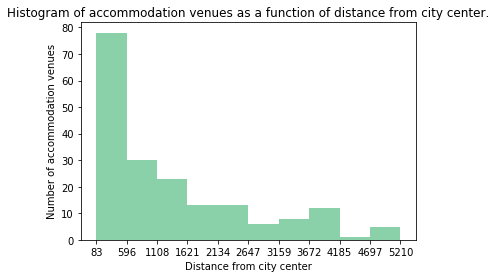

In [283]:
# Histogram of accomodiation venues based on distance
#bins = np.linspace(min(accommodations['Distance to center']), max(accommodations['Distance to center']), 10)
#accommodations["Distance to center binned"]=pd.cut(accommodations["Distance to center"], bins, include_lowest=True)


count,bin_edges = np.histogram(accommodations['Distance to center'],10)

accommodations['Distance to center'].plot(kind='hist',
                                          xticks=bin_edges,
                                          bins=10,
                                          alpha=0.6,
                                          color=['mediumseagreen'])
plt.title("Histogram of accommodation venues as a function of distance from city center.")
plt.ylabel("Number of accommodation venues")
plt.xlabel("Distance from city center")
plt.show()

Here we see that 78 accommodation object are in the radius of 600 meters from city center. We expect that the candidate locations will be mostly outside of that area. 

Let's generate candidate locations for the new accommodation venue. 

In [298]:
walking_distance = 400 # meters, this corresponds to 5 minutes of walking.
subgrid_unit = 100 # meters, this corresponds to a good minute of walking.

# Within each grid area create a finer grid and calculate square centers of each subgrid square. 
# This will represent the potential accommodation locations.

location_candidates = []
for area in grid:
    subgrid = generate_grid(area[0][0], area[0][1], grid_unit, subgrid_unit)
    for subarea in subgrid:
        subarea_center = calculate_square_center(subarea[0][0], subarea[0][1], subgrid_unit)
        location_candidates.append(subarea_center)


In [300]:
# create a Dataframe of location candidates

locations = pd.DataFrame(location_candidates, columns = ['Latitude', 'Longitude'])
print("Number of location candidates before filtering:", len(locations))
locations.head()

Number of location candidates before filtering: 10000


,Latitude,Longitude
0,46.006856,14.442187
1,46.006856,14.443478
2,46.006856,14.444769
3,46.006856,14.446061
4,46.006856,14.447352


In [301]:
# For each accommodation get the number of other accommodation in walking distance and nearest accommodation

def get_number_of_nearby_accommodation(row, radius=walking_distance):
    count = 0
    for lat, lon in zip(accommodations['Latitude'], accommodations['Longitude']):
        dist = calculate_distance(row["Latitude"], row["Longitude"], lat, lon)
        if dist > 0 and dist < radius:
            count = count + 1
    return count
###          
    
def get_distance_to_nearest_accommodation(row):
    min_distance = 100000
    for lat, lon in zip(hotels['Latitude'], hotels['Longitude']):
        dist = calculate_distance(row["Latitude"], row["Longitude"], lat, lon)
        
        if dist > 0 and dist < min_distance:
            min_distance = dist
    return min_distance
###

locations['Number of nearby accommodation'] = locations.apply(lambda x: get_number_of_nearby_accommodation(x), axis=1)
locations['Distance to nearest accommodation'] = locations.apply(lambda x: get_distance_to_nearest_accommodation(x), axis=1) 




In [302]:
locations.head()

,Latitude,Longitude,Number of nearby accommodation,Distance to nearest accommodation
0,46.006856,14.442187,0,4204.372571
1,46.006856,14.443478,0,4143.310102
2,46.006856,14.444769,0,4083.782247
3,46.006856,14.446061,0,4025.857081
4,46.006856,14.447352,0,3969.604766


In [303]:
# For each accommodation get the number of bus stations in walking distance and nearest bus station

def get_number_of_nearby_bus_stations(row, radius=walking_distance):
    count = 0
    for lat, lon in zip(bus_stations['Latitude'], bus_stations['Longitude']):
        dist = calculate_distance(row["Latitude"], row["Longitude"], lat, lon)
        if dist > 0 and dist < radius:
            count = count + 1
    return count
###

def get_distance_to_nearest_bus_station(row):
    min_distance = 100000
    for lat, lon in zip(bus_stations['Latitude'], bus_stations['Longitude']):
        dist = calculate_distance(row["Latitude"], row["Longitude"], lat, lon)
        
        if dist > 0 and dist < min_distance:
            min_distance = dist
    return min_distance
###

locations['Number of nearby bus stations'] = locations.apply(lambda x: get_number_of_nearby_bus_stations(x), axis=1)          
locations['Distance to nearest bus station'] = locations.apply(lambda x: get_distance_to_nearest_bus_station(x), axis=1) 




In [304]:
locations.head()

,Latitude,Longitude,Number of nearby accommodation,Distance to nearest accommodation,Number of nearby bus stations,Distance to nearest bus station
0,46.006856,14.442187,0,4204.372571,0,2619.804258
1,46.006856,14.443478,0,4143.310102,0,2621.271032
2,46.006856,14.444769,0,4083.782247,0,2626.545350
3,46.006856,14.446061,0,4025.857081,0,2635.604353
4,46.006856,14.447352,0,3969.604766,0,2648.409205


In [305]:
# For each accommodation get the number of food venues in walking distance and nearest food venue
def get_number_of_nearby_food_venues(row, radius = walking_distance):
    count = 0
    for lat, lon in zip(food_venues['Latitude'], food_venues['Longitude']):
        dist = calculate_distance(row["Latitude"], row["Longitude"], lat, lon)
        if dist > 0 and dist <= radius:
            count = count + 1
    return count
###         
    
def get_distance_to_nearest_food_venue(row):
    min_distance = 100000
    for lat, lon in zip(food_venues['Latitude'], food_venues['Longitude']):
        dist = calculate_distance(row["Latitude"], row["Longitude"], lat, lon)
        
        if dist > 0 and dist < min_distance:
            min_distance = dist
    return min_distance
###

locations['Number of nearby food venues'] = locations.apply(lambda x: get_number_of_nearby_food_venues(x), axis=1) 
locations['Distance to nearest food venue'] = locations.apply(lambda x: get_distance_to_nearest_food_venue(x), axis=1) 



In [311]:
# calculate the location distance to the city center:

locations['Distance to center'] = locations.apply(lambda x: 
                                        calculate_distance(
                                            lj_center_lat, lj_center_lon, 
                                            x["Latitude"], x["Longitude"]), axis=1)

In [313]:
locations.head()

,Latitude,Longitude,Number of nearby accommodation,Distance to nearest accommodation,Number of nearby bus stations,Distance to nearest bus station,Number of nearby food venues,Distance to nearest food venue,Distance to center
0,46.006856,14.442187,0,4204.372571,0,2619.804258,0,2719.359009,7000.357157
1,46.006856,14.443478,0,4143.310102,0,2621.271032,0,2715.496240,6930.065753
2,46.006856,14.444769,0,4083.782247,0,2626.545350,0,2715.311605,6860.510620
3,46.006856,14.446061,0,4025.857081,0,2635.604353,0,2717.382964,6791.714379
4,46.006856,14.447352,0,3969.604766,0,2648.409205,0,2709.688064,6723.700324


Now we have a collection of 10k candidate locations. Let's filter out the locations that fit our assumptions. 

In [393]:
# Select the locations that have at least one bus station within the walking distance.
# Select the locations that have at least 3 food venues within the walking distance.
# Select the locations that do not have another accommodation in vicinity
# Select the locations that are nearer the city center

loc1 = locations[locations['Number of nearby bus stations'] > 0]
loc2 = loc1[loc1['Number of nearby food venues'] > 2]
loc3 = loc2[loc2['Number of nearby accommodation'] == 0]
final_locations = loc3[loc3['Distance to center'] < 3500] 
final_locations.reset_index(drop=True, inplace=True)

In [394]:
print(len(final_locations),"candidate locations were found.")
final_locations.head()

902 candidate locations were found.


,Latitude,Longitude,Number of nearby accommodation,Distance to nearest accommodation,Number of nearby bus stations,Distance to nearest bus station,Number of nearby food venues,Distance to nearest food venue,Distance to center
0,46.023945,14.524831,0,2124.913829,1,359.460898,5,189.631676,3379.528671
1,46.023945,14.526122,0,2192.463505,1,305.887278,4,118.832305,3423.623583
2,46.032044,14.482224,0,659.789509,1,398.206724,6,184.858517,2836.647572
3,46.032044,14.483516,0,577.705141,1,370.757783,7,199.595201,2772.558487
4,46.032044,14.484808,0,502.158137,1,369.259473,6,246.614782,2710.642797


In [395]:
# Display candidate locations on the map
map_lj= folium.Map(location=lj_center_coordinates, zoom_start=13)
folium.Marker(lj_center_coordinates, popup=lj_center_address).add_to(map_lj)

for square in grid:
    folium.Rectangle(square, weight=0.7).add_to(map_lj)

for lat, lon in zip(final_locations['Latitude'], final_locations['Longitude']):
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.3,
        parse_html=False).add_to(map_lj)  
    
map_lj

Here we can observe that there are bigger areas of candidate locations to the north of the city center.

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# set color scheme for the clusters
x = np.arange(number_of_clusters)
ys = [i+x+(i*x)**2 for i in range(number_of_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



In [409]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

number_of_clusters = 30

location_coordinates = final_locations[['Latitude', 'Longitude']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=1).fit(location_coordinates)

kmeans_centers = kmeans.cluster_centers_

# Display center points of the location clusters

map_lj= folium.Map(location=lj_center_coordinates, zoom_start=13)
folium.Marker(lj_center_coordinates, popup=lj_center_address).add_to(map_lj)

for square in grid:
    folium.Rectangle(square, weight=0.7).add_to(map_lj)

for lat, lon in zip(final_locations['Latitude'], final_locations['Longitude']):
    
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color='red',
        fill_opacity=0.2,
        parse_html=False).add_to(map_lj)  


for lat, lon in kmeans_centers:
      folium.Circle([lat, lon],
                    radius=400, 
                    color='green', 
                    fill=True, 
                    fill_color='#0066ff',
                    weight=0.5,
                    fill_opacity=0.2).add_to(map_lj)
        
for lat, lon in kmeans_centers:
      folium.CircleMarker([lat, lon],
                    radius=3, 
                    color='black',
                    fill=True, 
                    fill_color='black',
                    weight=1,
                    fill_opacity=0.4).add_to(map_lj)
    
map_lj


In [ ]:
# Get the addresses of the cluster centers that are start of the investigation 

In [400]:
addresses = []
for lat,lon in kmeans_centers:
    address = get_address_from_coordinates(lat, lon)
    address = address.split(', Ljubljana')[0]
    addresses.append(address)

In [401]:
print(addresses)

['4, Glonarjeva ulica, Kodeljevo, Vodmat', '2, Karingerjeva ulica, Draveljska gmajna', '108, Vodovodna cesta, Bratovševa ploščad, Bežigrad', '5, Baznikova ulica, London, Galjevica', '62, Jamova cesta, Vrtača, Vič', 'Savska cesta, Savsko naselje, Vodmat', 'Harvey Norman, Španska ulica, BTC, Moste', '5, Detelova ulica, Zupančičeva Jama, Bežigrad', 'Telekom - Vojkova, Vojkova cesta, Zupančičeva Jama, Bežigrad', 'eurolux, 44A, Litostrojska cesta, Industrijska cona Šiška, Šiška', 'Petrol - Ljubljana - Litijska, 31, Litijska cesta, Kodeljevo, Štepanja vas', 'učilnica, uprava, 70, Večna pot, Vrtača, Rožna dolina', '34, Dolenjska cesta, London, Rakovnik', 'Kovačičeva ulica, Atrium, Nove Jarše', '98, Koprska ulica, Vrtača, Vič', '4, Adamičeva ulica, Dravlje', '84A, Ob dolenjski železnici, London, Rudnik', '13a, Trstenjakova ulica, Zupančičeva Jama, Bežigrad', '11, Ulica Mire Miheličeve, Kodeljevo, Štepanjsko naselje', 'Cesta Dolomitskega odreda, Kosovo Polje, Vrhovci', '16, V Murglah, Krakovo, 